In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

#import os
#os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
#sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes

2022-08-18 13:01:42.534650: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-18 13:01:53.502679: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-18 13:01:53.554990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-18 13:01:53.555030: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-18 13:01:53.557213: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-18 13:01:53.559404: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [3]:
df_params.head()

Va          Vb         Vc          Vd         Ve         Vf  \
0  360.066204   69.840434  33.468912  283.316201  79.328098  35.847305   
1  271.955874  101.868916  28.546540  347.711607  84.727223  41.786928   
2  310.495835   79.551016  51.789526  197.624749  51.961358  40.627957   
3  368.363031   99.843451  51.223075  312.732434  89.436871  49.564425   
4  252.138904   90.823276  43.880020  293.190760  87.402367  59.800131   

         ba        bb        bc        bd  ...       kaa       kbd        kce  \
0  0.007714  0.009772  0.010261  0.008996  ...  2.316063  2.874391  88.732068   
1  0.008341  0.012020  0.013054  0.010064  ...  4.883066  3.640181  99.577576   
2  0.010750  0.015593  0.009346  0.013251  ...  3.245317  4.944193  34.494922   
3  0.008238  0.010022  0.007271  0.007357  ...  2.941270  2.693431  89.807684   
4  0.008995  0.008820  0.007773  0.011784  ...  4.101435  3.625196  60.758534   

         kda        keb       kee       kfe       mua     mulva    n  
0   9.363779   9.627162  0.275728  5.519184  4.664757  1.485684  2.0  
1   9.439324   7.552942  0.252092  4.607892  2.973656  1.423090  2.0  
2  13.954478   8.398245  0.299176  4.757444  4.151729  1.129469  2.0  
3  10.478264   7.656785  0.347844  6.552310  3.452419  1.213001  2.0  
4   9.479563  10.618988  0.174654  3.911595  4.190837  1.634196  2.0  

[5 rows x 24 columns]

In [4]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


# Test two: Using mask

In [5]:
ID = 194
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select a subset of data
t_star = t_star[-2:]
T = len(t_star)
data = data[:, :, :, -2::]

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])[dataset['pde_mask'] > 0, :]


In [6]:
layers = [3, 4*1024, 4*1024, 1024, 1024, 1024, 6]
#layers = [3, 1024, 512, 256, 128, 64, 6]
#layers = [3, 1024, 1024, 512, 256, 128, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_loss = Circuit2_variant5716(dtype=tf.float32, 
        D_A=df_params.d_A[ID],
        D_B = df_params.d_B[ID],
        b_A=df_params.ba[ID],
        b_B=df_params.bb[ID],
        b_C=df_params.bc[ID],
        b_D=df_params.bd[ID],
        b_E=df_params.be[ID],
        b_F=df_params.bf[ID],
        V_A=df_params.Va[ID],
        V_B=df_params.Vb[ID],
        V_C=df_params.Vc[ID],
        V_D=df_params.Vd[ID],
        V_E=df_params.Ve[ID],
        V_F=df_params.Vf[ID],
        k_AA=df_params.kaa[ID],
        k_BD=df_params.kbd[ID],
        k_CE=df_params.kce[ID],
        k_DA=df_params.kda[ID],
        k_EB=df_params.keb[ID],
        k_EE=df_params.kee[ID],
        k_FE=df_params.kfe[ID],
        mu_A=df_params.mua[ID],
        mulv_A=df_params.mulva[ID])

model = TINN_multi_nodes(pinn, 
                pde_loss, 
                nodes_n = nodes_n,
                node_names = node_names,
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                alpha = 0.9, 
                print_precision=".10f")

In [7]:
results = model.train(
        epochs = 5,
        batch_size = 32,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)

model.optimizer.lr.assign(1e-4)

results2 = model.train(
        epochs = 50,
        batch_size = 32,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)




Start of epoch 0


2022-08-18 13:02:20.794478: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-18 13:03:15.381116: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 1115.4282226562
total loss: 8821.4280512333, total regularisd loss (sum of batches): 12411242.8366699219
obs A loss: 2.8049412385, pde A loss: 824.1909373254
obs B loss: 4.5480088994, pde B loss: 63.2108406942
obs C loss: 4.1876417744, pde C loss: 10.6538120658
obs D loss: 6295.9365394115, pde D loss: 967.2861985770
obs E loss: 259.4024900696, pde E loss: 148.8583397358
obs F loss: 125.6928868848, pde F loss: 114.6554177568
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 357.85s

Start of epoch 1
Training observations acc over epoch: 1066.6234130859
total loss: 7745.3038669825, total regularisd loss (sum of batches): 10895476.5395507812
obs A loss: 1.90287235

Training observations acc over epoch: 275.2302551270
total loss: 3350.2553651929, total regularisd loss (sum of batches): 14305174.1210937500
obs A loss: 1.2583324315, pde A loss: 975.0948545337
obs B loss: 1.4702566379, pde B loss: 95.7652070448
obs C loss: 7.6340620132, pde C loss: 6.4697379499
obs D loss: 1341.4553011954, pde D loss: 352.8135273869
obs E loss: 189.6311505400, pde E loss: 77.1301431172
obs F loss: 109.9317910094, pde F loss: 191.6010022275
lambda obs A: 0.3878070116, lambda pde A: 0.8081098795
lambda obs B: 0.3883022070, lambda pde B: 0.4016098380
lambda obs C: 0.3934564590, lambda pde C: 0.3889142573
lambda obs D: 6.6060314178, lambda pde D: 0.4053215981
lambda obs E: 0.8408378959, lambda pde E: 0.3935369551
lambda obs F: 0.5499653220, lambda pde F: 0.4361064136

Time taken: 204.23s

Start of epoch 6
Training observations acc over epoch: 254.1998901367
total loss: 2880.1356642246, total regularisd loss (sum of batches): 12747431.3415527344
obs A loss: 1.7711624454, 

Training observations acc over epoch: 188.9360198975
total loss: 1919.5681031048, total regularisd loss (sum of batches): 10727342.4476318359
obs A loss: 11.0061083605, pde A loss: 351.0125484765
obs B loss: 1.1702518949, pde B loss: 83.4603193058
obs C loss: 3.7582525887, pde C loss: 10.5950171236
obs D loss: 981.9210654050, pde D loss: 275.3702428768
obs E loss: 112.5207504230, pde E loss: 54.7142670150
obs F loss: 23.2387202554, pde F loss: 10.8005576345
lambda obs A: 0.1670493484, lambda pde A: 0.4678420424
lambda obs B: 0.1392718554, lambda pde B: 0.2625079155
lambda obs C: 0.1605276018, lambda pde C: 0.1426749825
lambda obs D: 7.3838844299, lambda pde D: 0.2340108305
lambda obs E: 1.9796547890, lambda pde E: 0.1804224253
lambda obs F: 0.6627897024, lambda pde F: 0.2193641365

Time taken: 202.59s

Start of epoch 16
Training observations acc over epoch: 185.6109008789
total loss: 1858.8438687325, total regularisd loss (sum of batches): 10719531.4615478516
obs A loss: 10.4056501763,

Training observations acc over epoch: 181.0122528076
total loss: 1899.1482742429, total regularisd loss (sum of batches): 11583310.7867431641
obs A loss: 6.9442988506, pde A loss: 380.4701350182
obs B loss: 1.1469683805, pde B loss: 65.7199944463
obs C loss: 3.4139176634, pde C loss: 12.4403226790
obs D loss: 944.0015013255, pde D loss: 290.5069114808
obs E loss: 110.1146496711, pde E loss: 55.6196249411
obs F loss: 20.4530410338, pde F loss: 8.3169097430
lambda obs A: 0.0778069794, lambda pde A: 0.3668976426
lambda obs B: 0.0524837747, lambda pde B: 0.1217991710
lambda obs C: 0.0784735158, lambda pde C: 0.0577318706
lambda obs D: 8.2857570648, lambda pde D: 0.1830023080
lambda obs E: 2.2305159569, lambda pde E: 0.0915675312
lambda obs F: 0.3716258407, lambda pde F: 0.0823381469

Time taken: 205.54s

Start of epoch 26
Training observations acc over epoch: 177.3478546143
total loss: 1801.8037496209, total regularisd loss (sum of batches): 11395354.8991699219
obs A loss: 6.6382854048, pd

Training observations acc over epoch: 174.1242828369
total loss: 1909.8740261793, total regularisd loss (sum of batches): 11671162.6150512695
obs A loss: 5.2836842665, pde A loss: 447.5187972672
obs B loss: 1.1305142317, pde B loss: 55.0380661944
obs C loss: 3.0657240186, pde C loss: 16.1732266895
obs D loss: 905.5907539912, pde D loss: 266.8361902090
obs E loss: 108.8613892766, pde E loss: 70.3273085798
obs F loss: 20.8139099041, pde F loss: 9.2344591586
lambda obs A: 0.0380710587, lambda pde A: 0.3240076602
lambda obs B: 0.0221985485, lambda pde B: 0.0699514151
lambda obs C: 0.0451103859, lambda pde C: 0.0308745019
lambda obs D: 8.6886663437, lambda pde D: 0.1551603377
lambda obs E: 2.2590713501, lambda pde E: 0.0580152199
lambda obs F: 0.2758030891, lambda pde F: 0.0330703333

Time taken: 206.43s

Start of epoch 36
Training observations acc over epoch: 176.5012359619
total loss: 2015.1977979839, total regularisd loss (sum of batches): 11861633.4340820312
obs A loss: 4.9863758211, pd

Training observations acc over epoch: 171.8407897949
total loss: 1970.6867488623, total regularisd loss (sum of batches): 11636453.0028076172
obs A loss: 5.1982178228, pde A loss: 442.1523668617
obs B loss: 1.1091964481, pde B loss: 73.3585008984
obs C loss: 3.6512487959, pde C loss: 23.0394146182
obs D loss: 889.6915363446, pde D loss: 309.0159617234
obs E loss: 108.8461997425, pde E loss: 78.6329964320
obs F loss: 22.5490907151, pde F loss: 13.4420217333
lambda obs A: 0.0210426748, lambda pde A: 0.2852007449
lambda obs B: 0.0115574999, lambda pde B: 0.0594158843
lambda obs C: 0.0334363207, lambda pde C: 0.0262249466
lambda obs D: 8.8156061172, lambda pde D: 0.1387201995
lambda obs E: 2.2888476849, lambda pde E: 0.0485540219
lambda obs F: 0.2545694411, lambda pde F: 0.0168245099

Time taken: 198.77s

Start of epoch 46
Training observations acc over epoch: 171.6845855713
total loss: 1943.4257667959, total regularisd loss (sum of batches): 11641782.4843750000
obs A loss: 5.1140162147, p

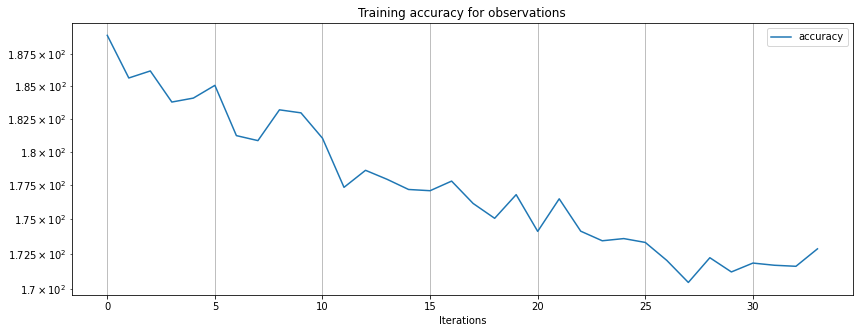

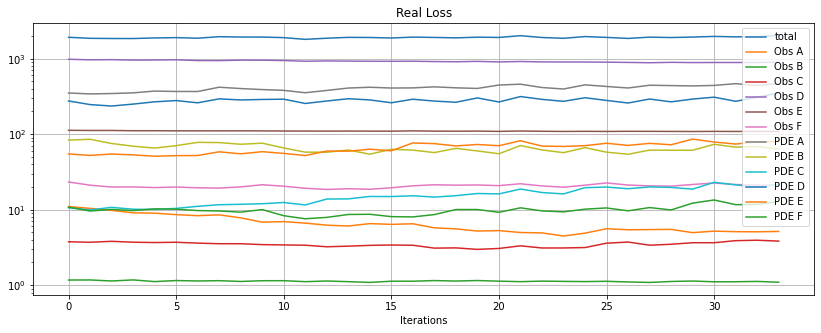

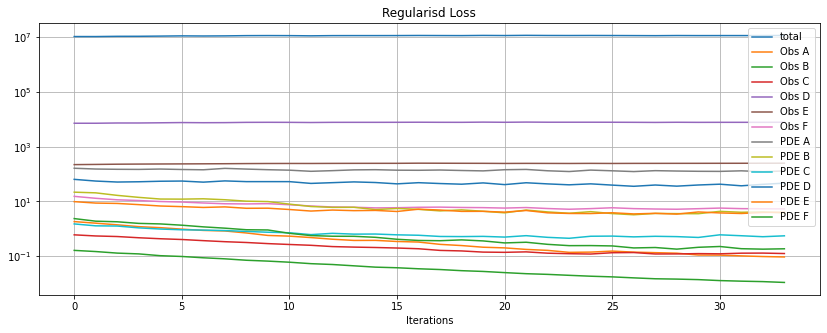

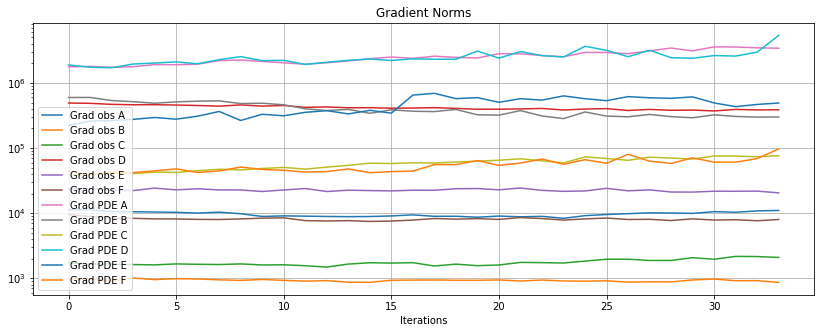

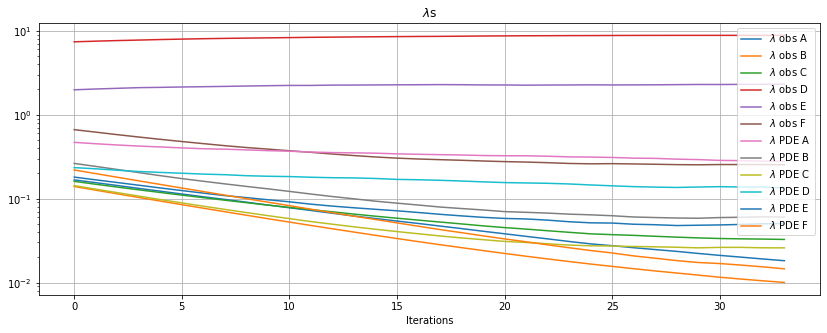

In [11]:
plot_result_multi_nodes(merge_dict_multi_nodes(results, results2), 
                        node_names=node_names, start=20,  yscale='log')

In [44]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

116


In [45]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

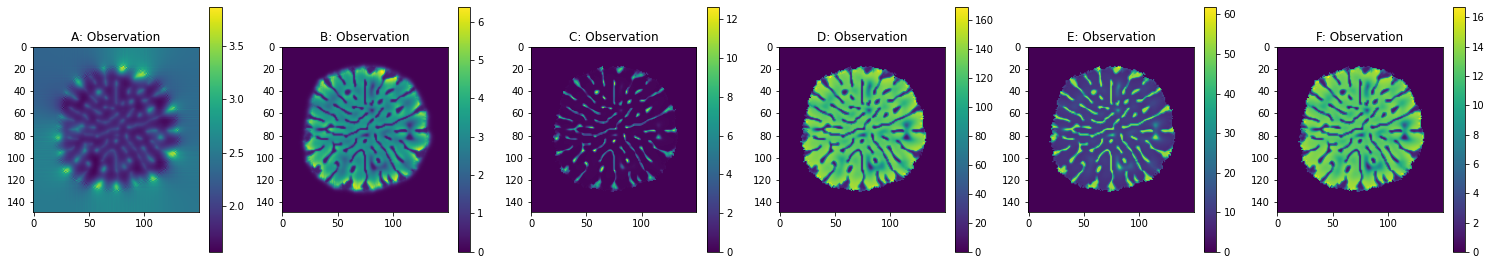

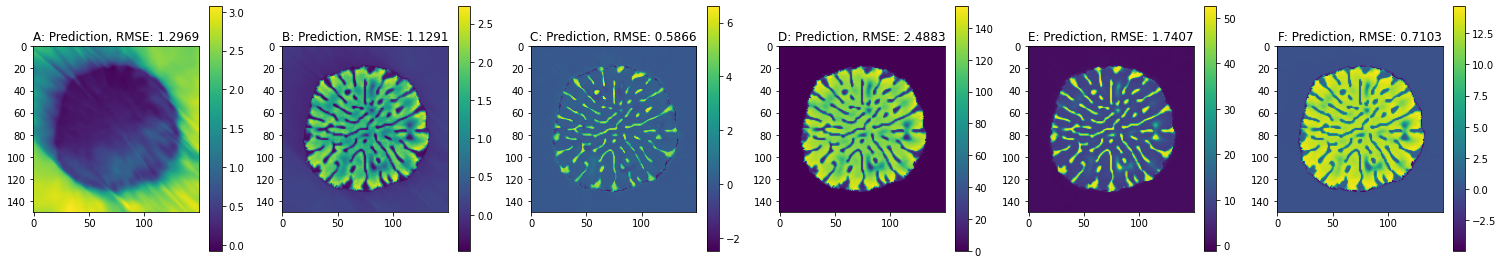

In [46]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data_original[i,:, :, t_star[T_test_index]])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

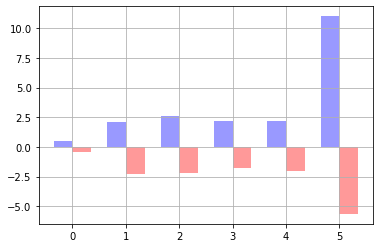

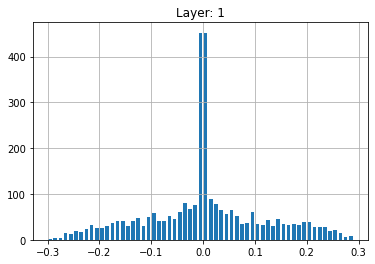

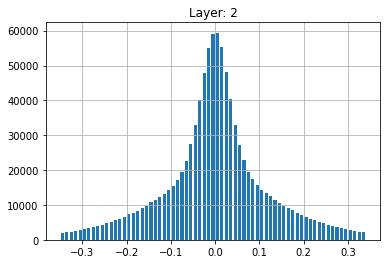

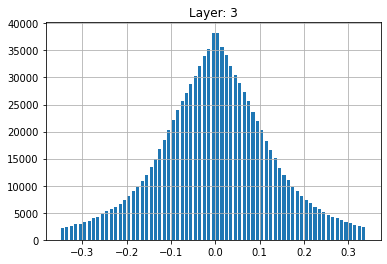

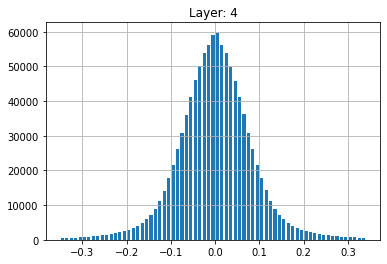

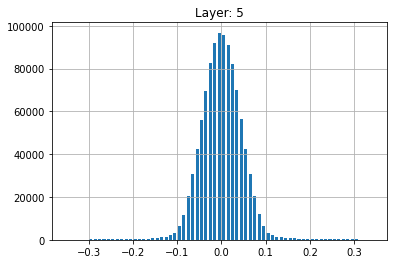

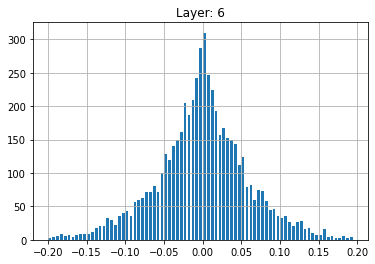

In [47]:
max_ws = np.zeros(len(pinn.Ws))
min_ws = np.zeros(len(pinn.Ws))
for i in range(len(pinn.Ws)):
    max_ws[i] = np.max(pinn.Ws[i].numpy())
    min_ws[i] = np.min(pinn.Ws[i].numpy())
    
index = np.arange(len(pinn.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

#bins = np.zeros((len(pinn.Ws), 50))
#hists = np.zeros((len(pinn.Ws), 49))
for i in range(len(pinn.Ws)):    
    if i == 0:
        bins = np.arange(-.3,.3,.01)
    elif i >= 1 and i <=4:
        bins = np.arange(-.35,0.35,.01)
    else:
        bins = np.arange(-.2,0.2,.005)
    #max_ws = np.max(pinn.Ws[i].numpy())
    #min_ws = np.min(pinn.Ws[i].numpy())
    #bins = np.arange(min_ws*.8, max_ws*.8, .8*(max_ws - min_ws)/20)
    hists, bins = np.histogram(pinn.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()


In [48]:
test_d = np.vstack([XX_test, YY_test, TT_test]).T

In [49]:
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pdes = np.zeros((test_d.shape[0], len(node_names)))

for i, _ in enumerate(test_d):
    outs, pde_outs = pde_loss.loss_multi_nodes(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pdes[i] = [item.numpy() for item in pde_outs]

In [50]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pdes = np.array([ test_pdes[:, i].reshape((x_size, y_size)) for i in range(test_pdes.shape[1])]) 

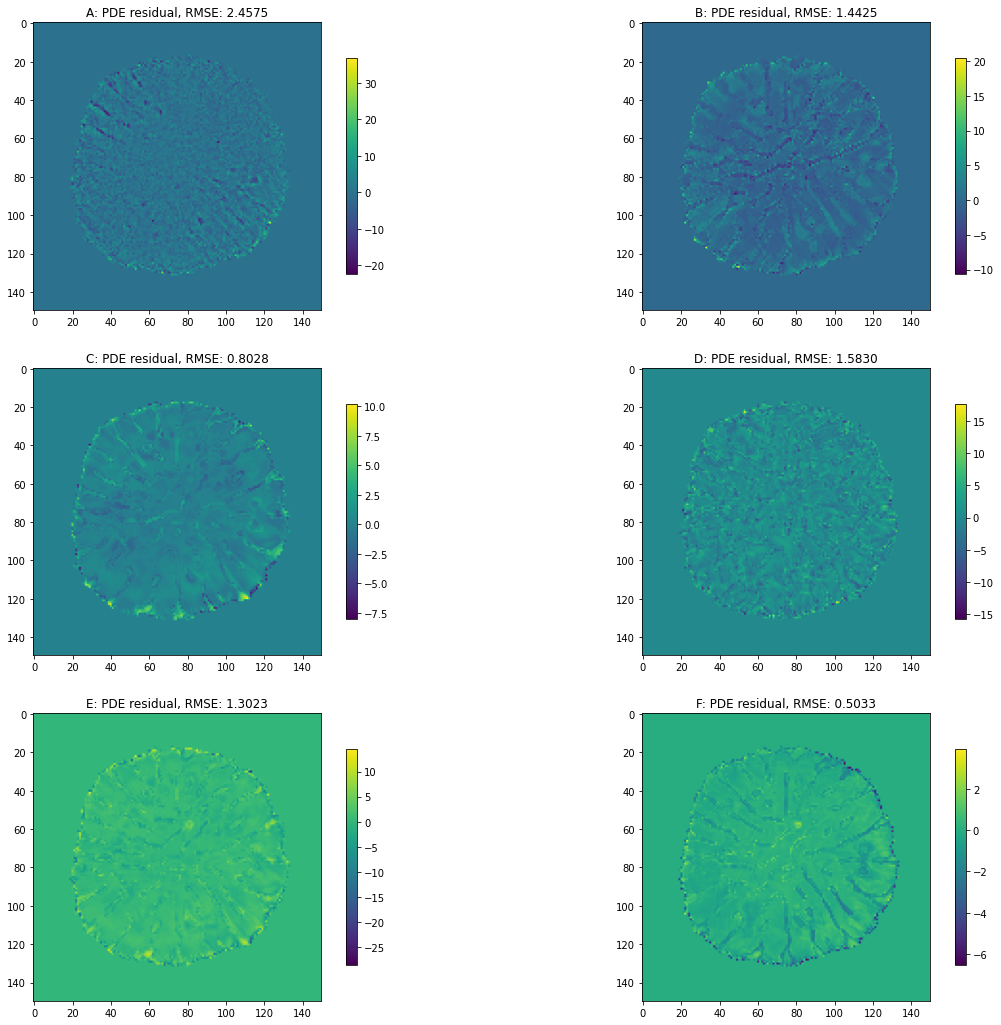

In [51]:
_ = plt.figure(figsize=(20,18))
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    rmse = np.sqrt(np.mean(d**2))
    plt.title(f"{name}: PDE residual, RMSE: {rmse:.4f}")
    
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()

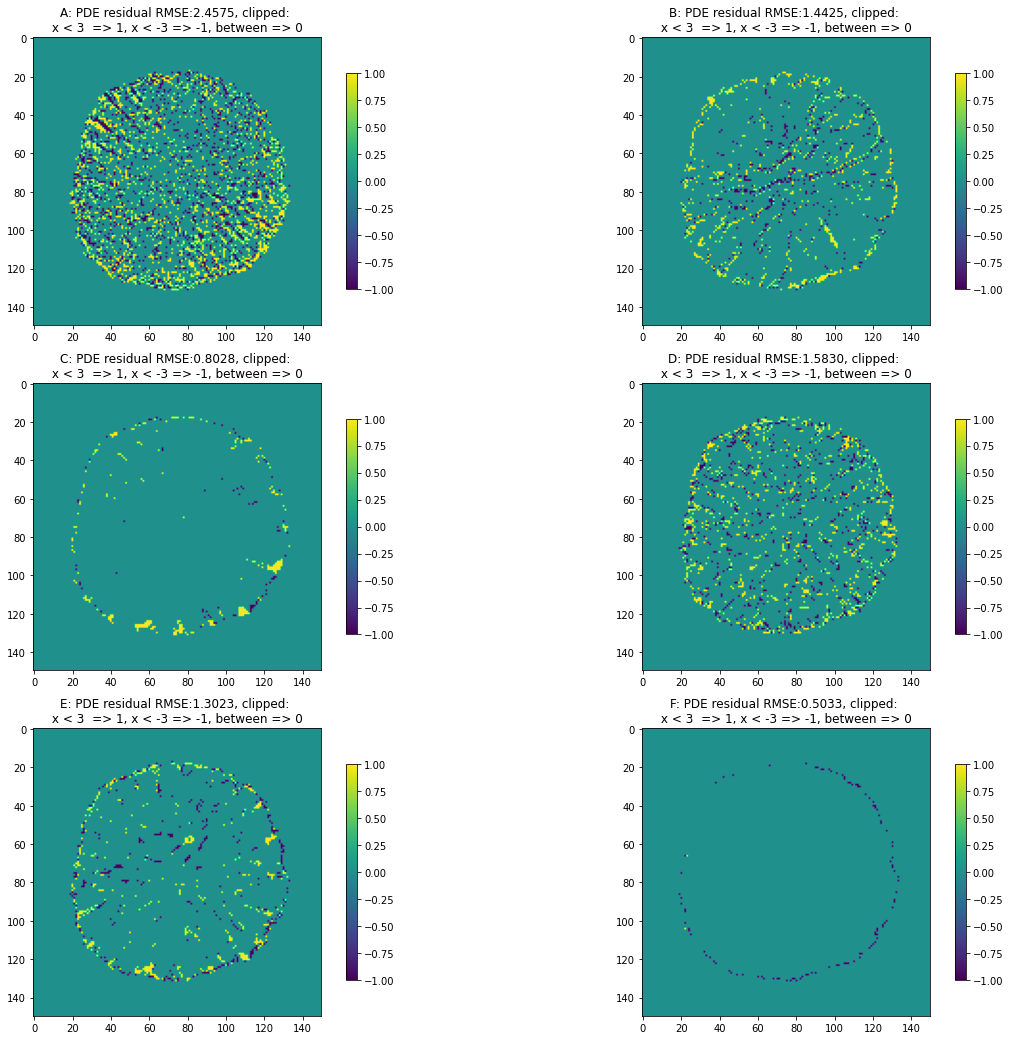

In [52]:
_ = plt.figure(figsize=(20,18))
max_L = 3
min_L = -3
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    rmse = np.sqrt(np.mean(d**2))
    plt.title(f"{name}: PDE residual RMSE:{rmse:.4f}, clipped: \n x < {max_L}  => 1, x < {min_L} => -1, between => 0 ")    
    d[(d >= min_L) & (d <= max_L)] = 0
    d[d > max_L] = 1
    d[d < min_L] = -1
    #d[d > 0] = 0
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()